In [61]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [71]:
class Layer(object):
    """define a layer object"""
    
    def __init__(self, n_input, n_output=None, random_seed=42):
        """Constructer of a layer object"""
        
        self.n_input = n_input
        self.n_output = n_output
        
        np.random.seed(random_seed)
        self.weights = np.random.uniform(-0.4, 0.4, size=(self.n_input, self.n_output))

    def _sigmoid_forward(self, x):
        """Apply sigmoid function"""
        
        return 1 / (1 + np.exp(-x))
    
    def _tanh_forward(self, x):
        """Apply tanh function"""
        
        return (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
    
    def forward_prop(self, input_x, activation_func='sigmoid', add_noise=False):
        """Implement forward propagation"""
        
        # add gaussian noises to input
        if add_noise:
            input_x += np.random.normal(0, 0.01, size=input_x.shape)
        
        if activation_func == 'sigmoid':
            self.out_x = self._sigmoid_forward(input_x.dot(self.weights))
        elif activation_func == 'tanh':
            self.out_x = self._tanh_forward(input_x.dot(self.weights))

    def backward_prop(self, x_pre, delta_next, weights_next, eta, activation_func='sigmoid'):
        """Implement backward propagation"""
        
        if activation_func == 'sigmoid':
            self.delta = self.out_x * (1-self.out_x) * delta_next.dot(weights_next.T)
        elif activation_func == 'tanh':
            self.delta = (1 - self._tanh_forward(self.out_x) ** 2) * delta_next.dot(weights_next.T)
        
        self.weights -= eta * x_pre.T.dot(self.delta) / x_pre.shape[0]
    
class Softmax_Layer(Layer):
    """define a output layer object"""
    
    def __init__(self, n_input, n_output=None, random_seed=42):
        """Constructer of a output layer object"""
            
        Layer.__init__(self, n_input, n_output, random_seed)
    
    def _softmax(self, out_x):
        return np.exp(out_x) / np.sum(np.exp(out_x))
    
    def forward_prop(self, input_x):
        """Implement forward propagation"""
        
        self.out_x = input_x.dot(self.weights)
        
    def backward_prop(self, y_true, y_preds, x_pre, eta):
        """Implement backward propagation (output layer)"""
        
        self.delta = 2 * (y_preds - y_true)
        
        self.weights -= eta * x_pre.T.dot(self.delta) / x_pre.shape[0]
    
    def predict(self):
        """Predict labels"""
        
        self.pred_proba = np.apply_along_axis(self._softmax, 1, self.out_x)
        return (self.pred_proba == self.pred_proba.max(axis=1)[:, None]).astype(int)
    
    def compute_mse(self, y_true):
        """Compute mean square error"""
        
        return np.mean(np.square(self.out_x - y_true))
    
    def compute_miscla_rate(self, y_true):
        """Compute misclassification rate"""
        
        return 1 - np.sum(np.all(output_layer.predict() == y_true, axis=1)) / y_true.shape[0]

## Task 1

In [157]:
X = np.array([[1, 0, 0], [1, 1, 0], [1, 0, 1], [1, 1, 1]])
y = np.array([[0, 1], [1, 0], [1, 0], [0, 1]])

In [158]:
epochs = 10000
n_neurons = 2
fc_layer = Layer(X.shape[1], n_neurons)
output_layer = Softmax_Layer(n_neurons, 2)

In [159]:
errors = np.zeros(epochs)
for epoch in range(epochs):
    fc_layer.forward_prop(X)
    output_layer.forward_prop(fc_layer.out_x)
    
    y_preds = output_layer.predict()
    output_layer.backward_prop(y, y_preds, x_pre=fc_layer.out_x, eta=0.035)
    fc_layer.backward_prop(x_pre=X, delta_next=output_layer.delta, weights_next=output_layer.weights, eta=0.035)
    
    errors[epoch] = output_layer.compute_mse(y)

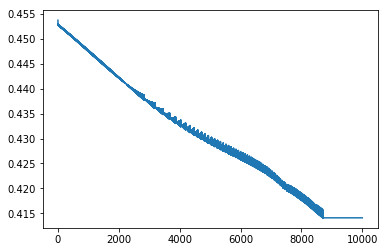

In [160]:
plt.plot(errors)

## Bonus Task

In [72]:
# load data
X = np.loadtxt('input/mfeat-pix.txt')

# normalize data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
# X = (X - np.min(X)) / (np.max(X) - np.min(X))

# add bias term
X = np.column_stack([np.ones(X.shape[0]), X])

# split the dataset into training data and test data
train_indices = [range(0 + 200*i, 100 + 200*i) for i in range(10)]
test_indices = [range(100 + 200*i, 200 + 200*i) for i in range(10)]

X_train = X[train_indices, ].reshape(1000, 241)
X_test = X[test_indices, ].reshape(1000, 241)

In [73]:
# create class labels
nb_classes = 10
y_vector = np.array([i for i in range(10) for j in range(100)])
y_matrix = np.eye(nb_classes)[y_vector]

In [76]:
# set the architecture
epochs = 50000
neurons_1 = 350
neurons_2 = 150
fc_layer1 = Layer(X.shape[1], neurons_1)
fc_layer2 = Layer(neurons_1, neurons_2)
output_layer = Softmax_Layer(neurons_2, 10)

train_miss = np.zeros(epochs)
test_miss = np.zeros(epochs)

In [77]:
for epoch in range(epochs):
    fc_layer1.forward_prop(X_train, add_noise=True)
    fc_layer2.forward_prop(fc_layer1.out_x, add_noise=True)
    output_layer.forward_prop(fc_layer2.out_x)
    
    train_miss[epoch] = output_layer.compute_miscla_rate(y_matrix)
    
    output_layer.backward_prop(y_matrix, output_layer.predict(), x_pre=fc_layer2.out_x, eta=0.001)
    fc_layer2.backward_prop(x_pre=fc_layer1.out_x, delta_next=output_layer.delta, weights_next=output_layer.weights, eta=0.01)
    fc_layer1.backward_prop(x_pre=X_train, delta_next=fc_layer2.delta, weights_next=fc_layer2.weights, eta=0.01)
    
    fc_layer1.forward_prop(X_test)
    fc_layer2.forward_prop(fc_layer1.out_x)
    output_layer.forward_prop(fc_layer2.out_x)
    
    test_miss[epoch] = output_layer.compute_miscla_rate(y_matrix)
    
    if epoch % 10 == 0:
        print(epoch, train_miss[epoch], test_miss[epoch])

0 0.896 0.878
10 0.883 0.87
20 0.847 0.839
30 0.81 0.806
40 0.769 0.744
50 0.7110000000000001 0.683
60 0.659 0.635
70 0.627 0.591
80 0.589 0.55
90 0.5589999999999999 0.512
100 0.5349999999999999 0.478
110 0.511 0.45799999999999996
120 0.48 0.43400000000000005
130 0.45599999999999996 0.41100000000000003
140 0.43700000000000006 0.393
150 0.41200000000000003 0.373
160 0.394 0.348
170 0.381 0.32899999999999996
180 0.361 0.31899999999999995
190 0.33599999999999997 0.30000000000000004
200 0.31799999999999995 0.28800000000000003
210 0.30500000000000005 0.274
220 0.30400000000000005 0.271
230 0.28200000000000003 0.264
240 0.278 0.248
250 0.268 0.245
260 0.262 0.238
270 0.261 0.23199999999999998
280 0.254 0.22799999999999998
290 0.248 0.22199999999999998
300 0.246 0.21799999999999997
310 0.22899999999999998 0.21099999999999997
320 0.22499999999999998 0.20399999999999996
330 0.21799999999999997 0.20199999999999996
340 0.20999999999999996 0.19799999999999995
350 0.20599999999999996 0.195999999999

KeyboardInterrupt: 